In [5]:
# Data and NBA API
import pandas as pd
import numpy as np

from scipy.stats import norm, gaussian_kde, percentileofscore

pd.options.display.max_columns = None
from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

# For Shot Chart
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [20]:
def get_player_shotchartdetail(player_name, season_id):
    """
    Parameters
    ----------
    player_name: name of the player with Capital
    season_id: ex. 2012-13
    """
    
    # player dictionary
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == player_name][0]
    
    # career df
    career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    career_df = career.get_data_frames()[0]
    
    # team id during the season
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']
    
    # shotchardtdetail endpoint
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id), 
                                                   player_id=int(player_dict['id']), 
                                                   season_type_all_star='Regular Season', 
                                                   season_nullable=season_id,
                                                   context_measure_simple="FGA").get_data_frames()
    
    return shotchartlist[0], shotchartlist[1]

In [21]:
player_shotchart_df, league_avg = get_player_shotchartdetail('Joel Embiid', '2020-21')

In [22]:
player_shotchart_df

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022000013,7,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,11,43,Missed Shot,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Center(C),8-16 ft.,14,-4,147,1,0,20201223,PHI,WAS
1,Shot Chart Detail,0022000013,48,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,8,1,Made Shot,Alley Oop Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-2,21,1,1,20201223,PHI,WAS
2,Shot Chart Detail,0022000013,58,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,6,45,Missed Shot,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,15,94,120,1,0,20201223,PHI,WAS
3,Shot Chart Detail,0022000013,83,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,4,56,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,10,-103,34,1,1,20201223,PHI,WAS
4,Shot Chart Detail,0022000013,95,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,4,13,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,20,9,200,1,1,20201223,PHI,WAS
5,Shot Chart Detail,0022000013,100,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,3,43,Made Shot,Putback Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,13,14,1,1,20201223,PHI,WAS
6,Shot Chart Detail,0022000013,202,203954,Joel Embiid,1610612755,Philadelphia 76ers,2,8,8,Missed Shot,Turnaround Fadeaway shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6,63,6,1,0,20201223,PHI,WAS
7,Shot Chart Detail,0022000013,210,203954,Joel Embiid,1610612755,Philadelphia 76ers,2,7,0,Missed Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,16,-11,168,1,0,20201223,PHI,WAS
8,Shot Chart Detail,0022000013,241,203954,Joel Embiid,1610612755,Philadelphia 76ers,2,5,16,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,26,-46,266,1,1,20201223,PHI,WAS
9,Shot Chart Detail,0022000013,549,203954,Joel Embiid,1610612755,Philadelphia 76ers,4,9,12,Made Shot,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,11,-115,1,1,1,20201223,PHI,WAS


In [9]:
def draw_court(ax=None, color="blue", lw=1, shotzone=False, outer_lines=False):
    """Returns an axes with a basketball court drawn onto to it.
    This function draws a court based on the x and y-axis values that the NBA
    stats API provides for the shot chart data.  For example the center of the
    hoop is located at the (0,0) coordinate.  Twenty-two feet from the left of
    the center of the hoop in is represented by the (-220,0) coordinates.
    So one foot equals +/-10 units on the x and y-axis.
    Parameters
    ----------
    ax : Axes, optional
        The Axes object to plot the court onto.
    color : matplotlib color, optional
        The color of the court lines.
    lw : float, optional
        The linewidth the of the court lines.
    outer_lines : boolean, optional
        If `True` it draws the out of bound lines in same style as the rest of
        the court.
    Returns
    -------
    ax : Axes
        The Axes object with the court on it.
    """
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
    # Draw shotzone Lines
    # Based on Advanced Zone Mode
    if (shotzone == True):
        inner_circle = Circle((0, 0), radius=80, linewidth=lw, color='black', fill=False)
        outer_circle = Circle((0, 0), radius=160, linewidth=lw, color='black', fill=False)
        corner_three_a_x =  Rectangle((-250, 92.5), 30, 0, linewidth=lw, color=color)
        corner_three_b_x = Rectangle((220, 92.5), 30, 0, linewidth=lw, color=color)
        
        # 60 degrees
        inner_line_1 = Rectangle((40, 69.28), 80, 0, 60, linewidth=lw, color=color)
        # 120 degrees
        inner_line_2 = Rectangle((-40, 69.28), 80, 0, 120, linewidth=lw, color=color)
        
        # Assume x distance is also 40 for the endpoint
        inner_line_3 = Rectangle((53.20, 150.89), 290, 0, 70.53, linewidth=lw, color=color)
        inner_line_4 = Rectangle((-53.20, 150.89), 290, 0, 109.47, linewidth=lw, color=color)
        
        # Assume y distance is also 92.5 for the endpoint
        inner_line_5 = Rectangle((130.54, 92.5), 80, 0, 35.32, linewidth=lw, color=color)
        inner_line_6 = Rectangle((-130.54, 92.5), 80, 0, 144.68, linewidth=lw, color=color)
        
        
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc, inner_circle, outer_circle,
                          corner_three_a_x, corner_three_b_x,
                          inner_line_1, inner_line_2, inner_line_3, inner_line_4, inner_line_5, inner_line_6]
    else:
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc]
    
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
        

    return ax

In [10]:
def sized_hexbin(ax, hc, hc2, cmap, norm):
    offsets = hc.get_offsets()
    orgpath = hc.get_paths()[0]
    verts = orgpath.vertices
    values1 = hc.get_array()
    values2 = hc2.get_array()
    ma = values1.max()
    patches = []

    for offset,val in zip(offsets,values1):
        # Adding condition for minimum size 
        # offset is the respective position of each hexagons
        
        # remove 0 to compare frequency without 0s
        filtered_list = list(filter(lambda num: num != 0, values1))
        
        # we also skip frequency counts that are 0s
        # this is to discount hexbins with no occurences
        # default value hexagons are the frequencies
        if (int(val) == 0):
            continue
        elif (percentileofscore(filtered_list, val) < 33.33):
            #print(percentileofscore(values1, val))
            #print("bot")
            v1 = verts*0.3 + offset
        elif (percentileofscore(filtered_list, val) > 69.99):
            #print(percentileofscore(values1, val))
            #print("top")
            v1 = verts + offset
        else:
            #print("mid")
            v1 = verts*0.6 + offset
        
        path = Path(v1, orgpath.codes)
        patch = PathPatch(path)
        patches.append(patch)

    pc = PatchCollection(patches, cmap=cmap, norm=norm)
    # sets color
    # so hexbin with C=data['FGP']
    pc.set_array(values2)

    ax.add_collection(pc)
    hc.remove()
    hc2.remove()

def hexmap_chart(data, league_avg, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="#1a477b", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):
    
    LA = league_avg.loc[:,['SHOT_ZONE_AREA','SHOT_ZONE_RANGE', 'FGA', 'FGM']].groupby(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    LA['FGP'] = 1.0*LA['FGM']/LA['FGA']
    player = data.groupby(['SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_MADE_FLAG']).size().unstack(fill_value=0)
    player['FGP'] = 1.0*player.loc[:,1]/player.sum(axis=1)
    player_vs_league = (player.loc[:,'FGP'] - LA.loc[:,'FGP'])*100  

    data = pd.merge(data, player_vs_league, on=['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'], how='right')
    
    if ax is None:
        ax = plt.gca()
        ax.set_facecolor(court_color)

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)

    x = data['LOC_X']
    y = data['LOC_Y']
        
    # for diverging color map
    colors = ['#2b7cb6', '#abd9e9', '#ffffbf', '#fdaf61', '#d7191c']
    cmap = ListedColormap(colors)
    # The 5 colors are separated by -9, -3, 0, 3, 9
    boundaries = [-np.inf, -9, -3, 0, 3, 9, np.inf]
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)   
    
    # first hexbin required for bincount
    # second hexbin for the coloring of each hexagons
    hexbin = ax.hexbin(x, y, gridsize=40, cmap=cmap, norm=norm, extent=[-275, 275, -50, 425])
    hexbin2 = ax.hexbin(x, y, C=data['FGP'], gridsize=40, cmap=cmap, norm=norm, extent=[-275, 275, -50, 425])
    sized_hexbin(ax, hexbin, hexbin2, cmap, norm) 
    
    # Set the spines to match the rest of court lines, makes outer_lines
    # somewhate unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

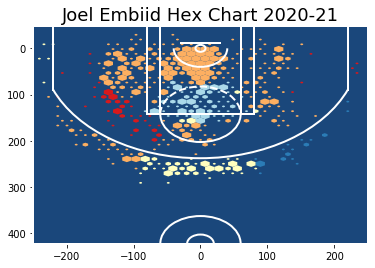

In [11]:
hexmap_chart(player_shotchart_df, league_avg, title="Joel Embiid Hex Chart 2020-21")
plt.show()

In [12]:
!jt -h

usage: jt [-h] [-l] [-t THEME] [-f MONOFONT] [-fs MONOSIZE] [-nf NBFONT]
          [-nfs NBFONTSIZE] [-tf TCFONT] [-tfs TCFONTSIZE] [-dfs DFFONTSIZE]
          [-ofs OUTFONTSIZE] [-mathfs MATHFONTSIZE] [-m MARGINS]
          [-cursw CURSORWIDTH] [-cursc CURSORCOLOR] [-cellw CELLWIDTH]
          [-lineh LINEHEIGHT] [-altp] [-altmd] [-altout] [-P] [-T] [-N] [-kl]
          [-vim] [-r] [-dfonts]

optional arguments:
  -h, --help            show this help message and exit
  -l, --list            list available themes
  -t THEME, --theme THEME
                        theme name to install
  -f MONOFONT, --monofont MONOFONT
                        monospace code font
  -fs MONOSIZE, --monosize MONOSIZE
                        code font-size
  -nf NBFONT, --nbfont NBFONT
                        notebook font
  -nfs NBFONTSIZE, --nbfontsize NBFONTSIZE
                        notebook fontsize
  -tf TCFONT, --tcfont TCFONT
                        txtcell font
  -tfs TCFONTSIZE, --tcfontsize TCF

In [13]:
!jt -t monokai -T

In [14]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [16]:
player_shotchart_df.columns

Index(['GRID_TYPE', 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME',
       'TEAM_ID', 'TEAM_NAME', 'PERIOD', 'MINUTES_REMAINING',
       'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE',
       'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 'GAME_DATE',
       'HTM', 'VTM'],
      dtype='object')

In [17]:
player_shotchart_df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022000013,7,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,11,43,Missed Shot,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Center(C),8-16 ft.,14,-4,147,1,0,20201223,PHI,WAS
1,Shot Chart Detail,0022000013,48,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,8,1,Made Shot,Alley Oop Dunk Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-2,21,1,1,20201223,PHI,WAS
2,Shot Chart Detail,0022000013,58,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,6,45,Missed Shot,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),8-16 ft.,15,94,120,1,0,20201223,PHI,WAS
3,Shot Chart Detail,0022000013,83,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,4,56,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,10,-103,34,1,1,20201223,PHI,WAS
4,Shot Chart Detail,0022000013,95,203954,Joel Embiid,1610612755,Philadelphia 76ers,1,4,13,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Center(C),16-24 ft.,20,9,200,1,1,20201223,PHI,WAS


In [19]:
player_shotchart_df['SHOT_ZONE_BASIC'].value_counts()

Mid-Range                285
Restricted Area          238
In The Paint (Non-RA)    222
Above the Break 3        145
Left Corner 3              5
Right Corner 3             3
Backcourt                  1
Name: SHOT_ZONE_BASIC, dtype: int64

In [ ]:
 left_corner_three = Polygon([(-250, -47.5), (-250, 92.5), (-220, 92.5), (-220, -47.5)])
    right_corner_three = Polygon([(250, -47.5), (250, 92.5), (220, 92.5), (220, -47.5)])
    
    left_base_jump = Polygon([(-220, -47.5), (-220, 92.5), (-125, 92.5), (-125, -47.5)])
    right_base_jump = Polygon([(220, -47.5), (220, 92.5), (125, 92.5), (125, -47.5)])
    
    left_near_basket = Polygon([(-125, -47.5), (-125, 142.5), (0, 142.5), (0, -47.5)])
    right_near_basket = Polygon([(125, -47.5), (125, 142.5), (0, 142.5), (0, -47.5)])
    
    ## Left & Right Wing 2s
    circle = Point(0,0).buffer(1)
    three_circle = shapely.affinity.scale(circle, 237.5, 237.5)
    
    #making two polygons that contain the area that I want. 
    #If point is inside polygon area and circle then it is in long 2 area
    left_two_polygon = Polygon([(-250, 250), (-250, 92.5), (-125, 92.5), (-125, 250)])
    right_two_polygon = Polygon([(250, 250), (250, 92.5), (125, 92.5), (125, 250)])
     
    ## Left & Right Above FT 2s
    left_two_above_FT = Polygon([(-125, 250), (-125, 142.5), (0, 142.5), (0, 250)])
    right_two_above_FT = Polygon([(125, 250), (125, 142.5), (0, 142.5), (0, 250)])
    
    ## Above 3 point line
    big_circle = shapely.affinity.scale(circle, 287.5, 287.5)
    
    left_three_polygon = Polygon([(-250,300), (-250,0), (-125, 0), (-125, 300)])
    right_three_polygon = Polygon([(250,300), (250,0), (125, 0), (125, 300)])
    
    left_mid_three_polygon = Polygon([(-125,300), (-125,0), (0, 0), (0, 300)])
    right_mid_three_polygon = Polygon([(125,300), (125,0), (0, 0), (0, 300)])
    
    if left_corner_three.contains(player_shot_location):
        print('3 pointer Left Corner')
    
    elif right_corner_three.contains(player_shot_location):
        print('3 pointer Right Corner')
        
    elif left_base_jump.contains(player_shot_location):
        print('2 pointer Left Baseline')
    
    elif right_base_jump.contains(player_shot_location):
        print('2 pointer Right Baseline')
        
    elif left_near_basket.contains(player_shot_location):
        print('2 pointer Left near basket')
        
    elif right_near_basket.contains(player_shot_location):
        print('2 pointer Right near basket')
        
    elif three_circle.contains(player_shot_location) & left_two_polygon.contains(player_shot_location):
        print('2 pointer Left wing')
        
    elif three_circle.contains(player_shot_location) & right_two_polygon.contains(player_shot_location):
        print('2 pointer Right wing')
        
    elif three_circle.contains(player_shot_location) & left_two_above_FT.contains(player_shot_location):
        print('2 pointer Left above FT')
        
    elif three_circle.contains(player_shot_location) & right_two_above_FT.contains(player_shot_location):
        print('2 pointer Right above FT')
        
    elif big_circle.contains(player_shot_location) & left_three_polygon.contains(player_shot_location):
        print('3 pointer Left')
        
    elif big_circle.contains(player_shot_location) & right_three_polygon.contains(player_shot_location):
        print('3 pointer Right')
        
    elif big_circle.contains(player_shot_location) & left_mid_three_polygon.contains(player_shot_location):
        print('3 pointer Middle Left')
    
    elif big_circle.contains(player_shot_location) & right_mid_three_polygon.contains(player_shot_location):
        print('3 pointer Middle Right')
        
    else:
        print('Out of bounds')